In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision import datasets, transforms, utils
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
z_dim = 64
num_classes = 10
batch_size = 128
lr = 2e-4
lambda_gp = 10
n_critic = 3
ema_decay = 0.999
epochs = 15

In [3]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

### Part 1: Model and Losses

In [4]:
# Generator G(z,y)
class Generator(nn.Module):
    def __init__(self, z_dim=64, num_classes=10, emb_dim=32):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, emb_dim)
        self.fc = nn.Linear(z_dim + emb_dim, 4*4*128)
        self.net = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(64, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.ReLU(True),
            nn.Conv2d(16, 1, 3, 1, 1), nn.Tanh()
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, z, y):
        y_emb = self.label_emb(y)
        x = torch.cat([z, y_emb], dim=1)
        x = self.fc(x).view(-1, 128, 4, 4)
        return self.net(x)

# Critic D(x,y) with Projection
class Critic(nn.Module):
    def __init__(self, num_classes=10, proj_dim=128):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, proj_dim, 4, 2, 1), nn.LeakyReLU(0.2, True)
        )
        self.embed = nn.Embedding(num_classes, proj_dim)
        self.w = nn.Parameter(torch.randn(proj_dim))

    def forward(self, x, y):
        h = self.trunk(x)
        f = h.sum(dim=[2,3])   # global sum pooling
        e_y = self.embed(y)
        proj = (f * e_y).sum(dim=1)
        out = torch.matmul(f, self.w)
        return out + proj


# Gradient Penalty
def gradient_penalty(D, real, fake, y):
    B = real.size(0)
    eps = torch.rand(B, 1, 1, 1, device=device)
    x_hat = (eps * real + (1 - eps) * fake).requires_grad_(True)
    hat_score = D(x_hat, y).mean()
    grad = torch.autograd.grad(
        outputs=hat_score, inputs=x_hat,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_norm = grad.view(B, -1).norm(2, dim=1)
    gp = ((grad_norm - 1)**2).mean()
    return gp

# EMA Generator
@torch.no_grad()
def ema_update(model, ema_model, decay=0.999):
    msd = model.state_dict()
    esd = ema_model.state_dict()
    for k in esd.keys():
        if k in msd:
            if esd[k].dtype.is_floating_point:
                esd[k].mul_(decay).add_(msd[k] * (1 - decay))
            else:
                esd[k] = msd[k]
    ema_model.load_state_dict(esd)


G = Generator(z_dim, num_classes).to(device)
D = Critic(num_classes).to(device)
G_ema = deepcopy(G)
for p in G_ema.parameters():
    p.requires_grad = False

opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.0, 0.9))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.0, 0.9))


Epoch 1/15: 100%|██████████| 468/468 [00:26<00:00, 17.81it/s]


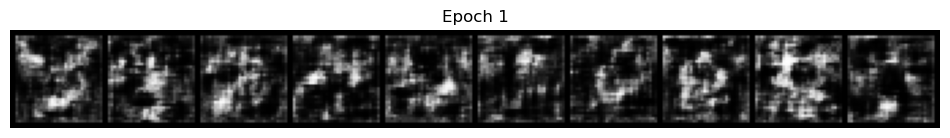

Epoch 2/15: 100%|██████████| 468/468 [00:25<00:00, 18.02it/s]


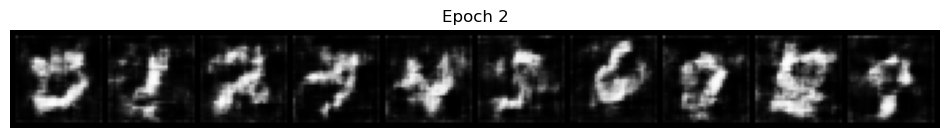

Epoch 3/15: 100%|██████████| 468/468 [00:25<00:00, 18.12it/s]


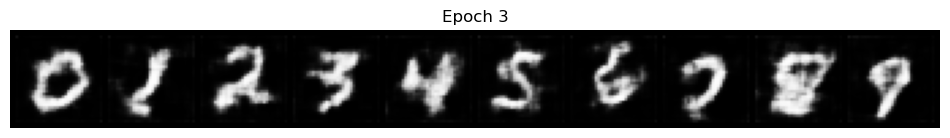

Epoch 4/15: 100%|██████████| 468/468 [00:26<00:00, 17.94it/s]


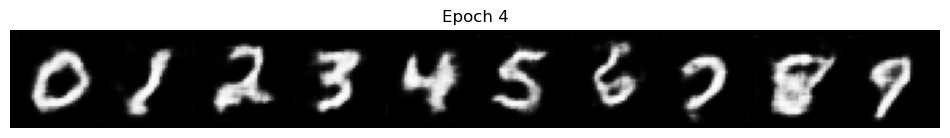

Epoch 5/15: 100%|██████████| 468/468 [00:27<00:00, 17.20it/s]


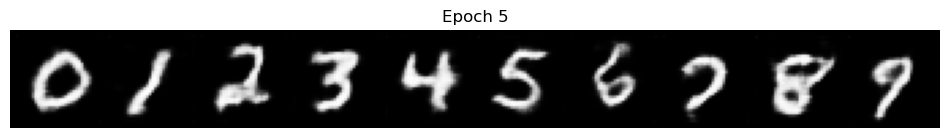

Epoch 6/15: 100%|██████████| 468/468 [00:27<00:00, 17.01it/s]


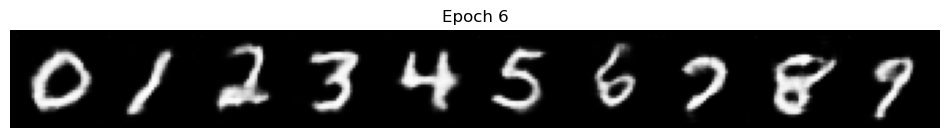

Epoch 7/15: 100%|██████████| 468/468 [00:26<00:00, 17.98it/s]


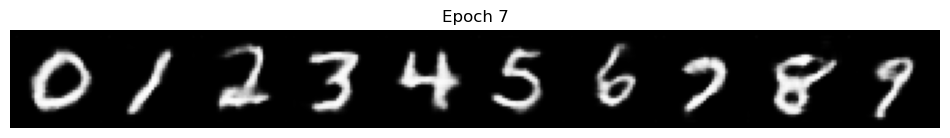

Epoch 8/15: 100%|██████████| 468/468 [00:25<00:00, 18.04it/s]


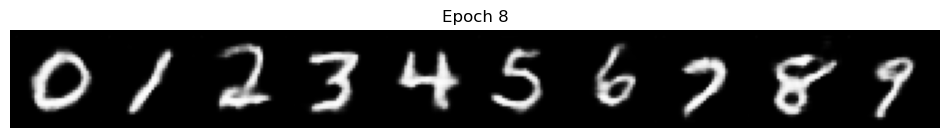

Epoch 9/15: 100%|██████████| 468/468 [00:25<00:00, 18.12it/s]


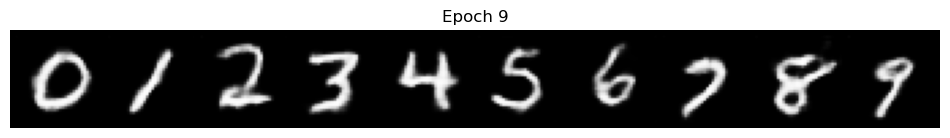

Epoch 10/15: 100%|██████████| 468/468 [00:26<00:00, 17.90it/s]


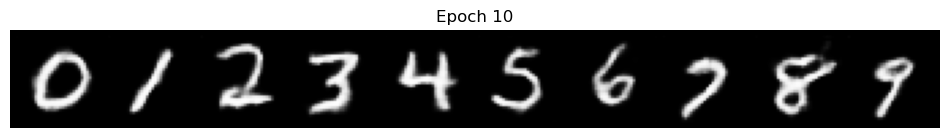

Epoch 11/15: 100%|██████████| 468/468 [00:25<00:00, 18.05it/s]


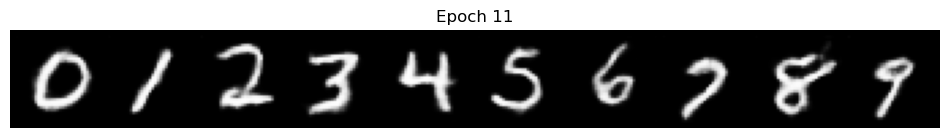

Epoch 12/15: 100%|██████████| 468/468 [00:27<00:00, 17.01it/s]


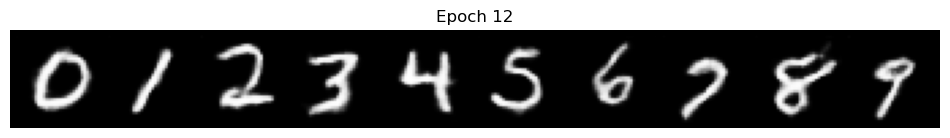

Epoch 13/15: 100%|██████████| 468/468 [00:25<00:00, 18.16it/s]


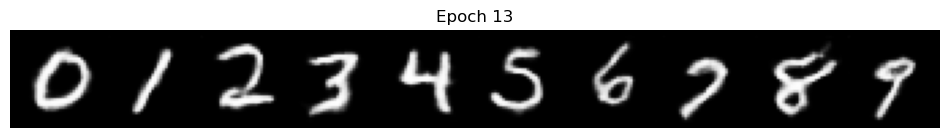

Epoch 14/15: 100%|██████████| 468/468 [00:25<00:00, 18.18it/s]


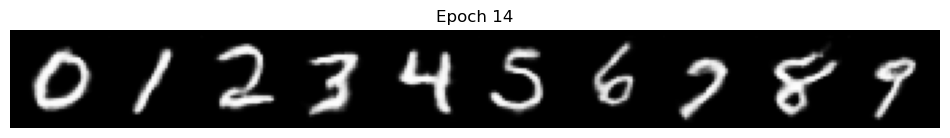

Epoch 15/15: 100%|██████████| 468/468 [00:25<00:00, 18.07it/s]


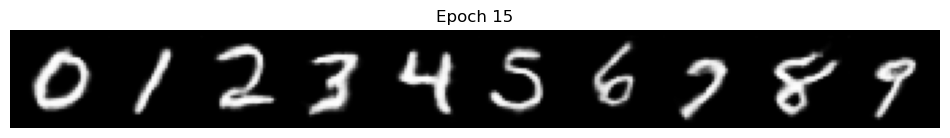

In [5]:
D_losses, G_losses, gp_vals, real_scores, fake_scores = [], [], [], [], []
fixed_z = torch.randn(10, z_dim, device=device)
fixed_y = torch.arange(10, device=device)

for epoch in range(epochs):
    for real, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        real, y = real.to(device), y.to(device)
        B = real.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(B, z_dim, device=device)
            fake = G(z, y).detach()
            real_score = D(real, y).mean()
            fake_score = D(fake, y).mean()
            gp = gradient_penalty(D, real, fake, y)
            loss_D = -(real_score - fake_score) + lambda_gp * gp

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

        # Train Generator
        z = torch.randn(B, z_dim, device=device)
        fake = G(z, y)
        loss_G = -D(fake, y).mean()

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        ema_update(G, G_ema, ema_decay)

        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())
        gp_vals.append(gp.item())
        real_scores.append(real_score.item())
        fake_scores.append(fake_score.item())

    with torch.no_grad():
        G_ema.eval()
        samples = G_ema(fixed_z, fixed_y)
        grid = utils.make_grid(samples, nrow=10, normalize=True, value_range=(-1,1))
        plt.figure(figsize=(12,2))
        plt.imshow(grid.permute(1,2,0).cpu())
        plt.axis('off')
        plt.title(f"Epoch {epoch+1}")
        plt.show()

### Plot Losses

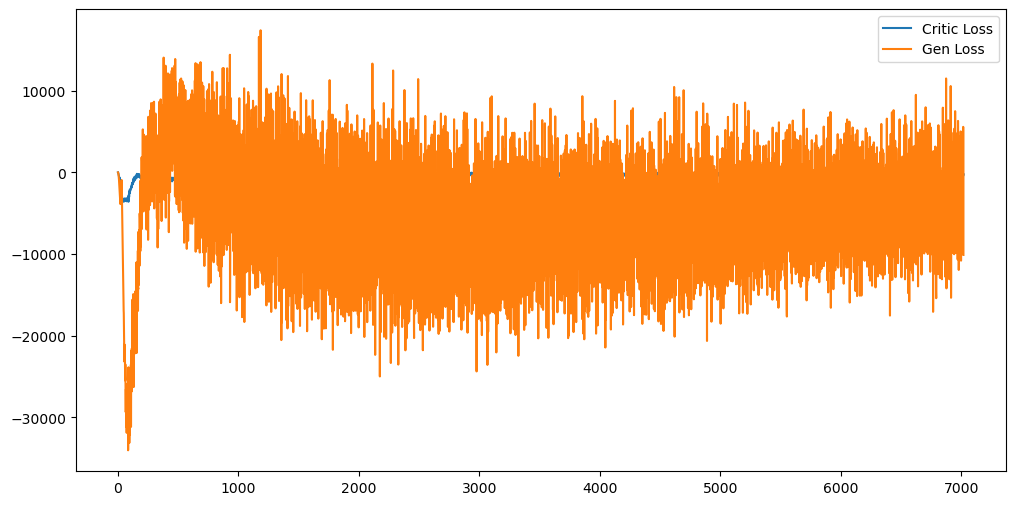

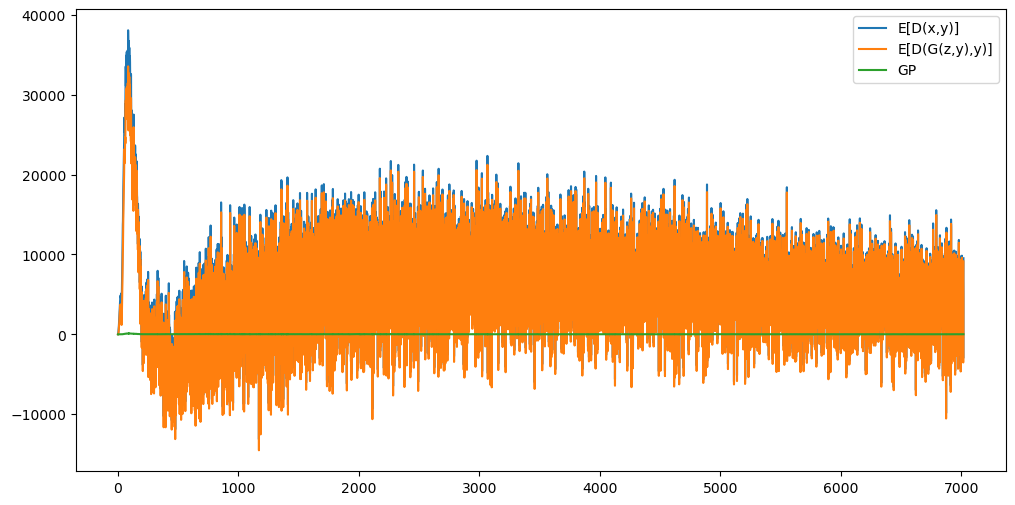

In [6]:
plt.figure(figsize=(12,6))
plt.plot(D_losses, label='Critic Loss')
plt.plot(G_losses, label='Gen Loss')
plt.legend(); plt.show()

plt.figure(figsize=(12,6))
plt.plot(real_scores, label='E[D(x,y)]')
plt.plot(fake_scores, label='E[D(G(z,y),y)]')
plt.plot(gp_vals, label='GP')
plt.legend(); plt.show()

### Part 3: Conditional Samples

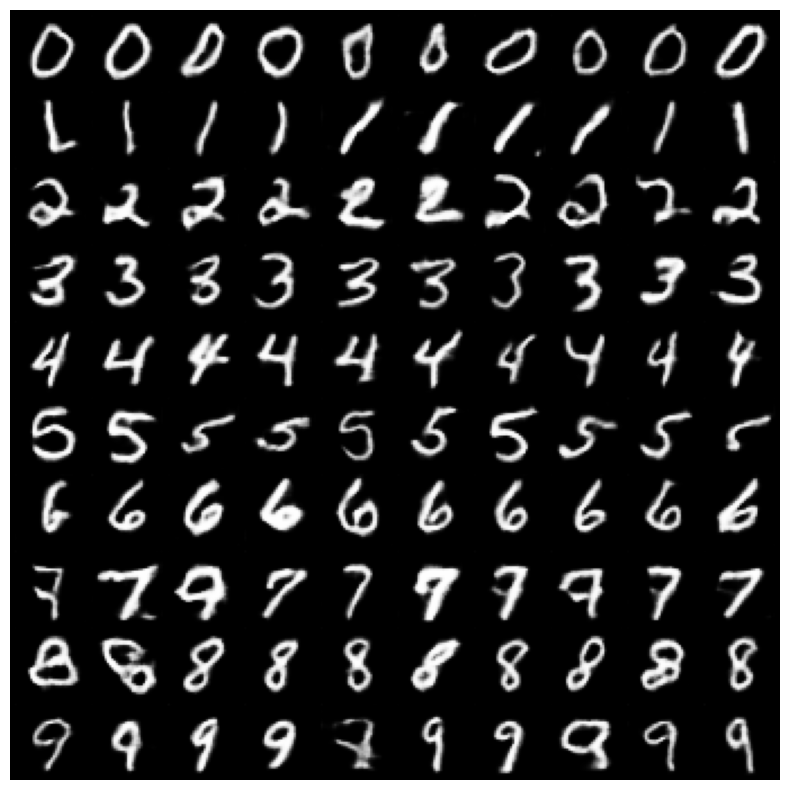

In [7]:
G_ema.eval()
N = 10  
num_rows = 10  

z = torch.randn(num_rows * N, z_dim, device=device)
labels = torch.arange(num_rows, device=device).repeat_interleave(N)

with torch.no_grad():
    fake_images = G_ema(z, labels)

grid = vutils.make_grid(fake_images, nrow=N, normalize=True, value_range=(-1, 1))

plt.figure(figsize=(N, num_rows))
plt.imshow(grid.permute(1, 2, 0).cpu())  # convert CHW -> HWC for matplotlib
plt.axis('off')
plt.show()

### Part 4: Latent Exploration and Truncation

In [8]:
G_ema.eval()

Generator(
  (label_emb): Embedding(10, 32)
  (fc): Linear(in_features=96, out_features=2048, bias=True)
  (net): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Upsample(scale_factor=2.0, mode='nearest')
    (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Tanh()
  )
)

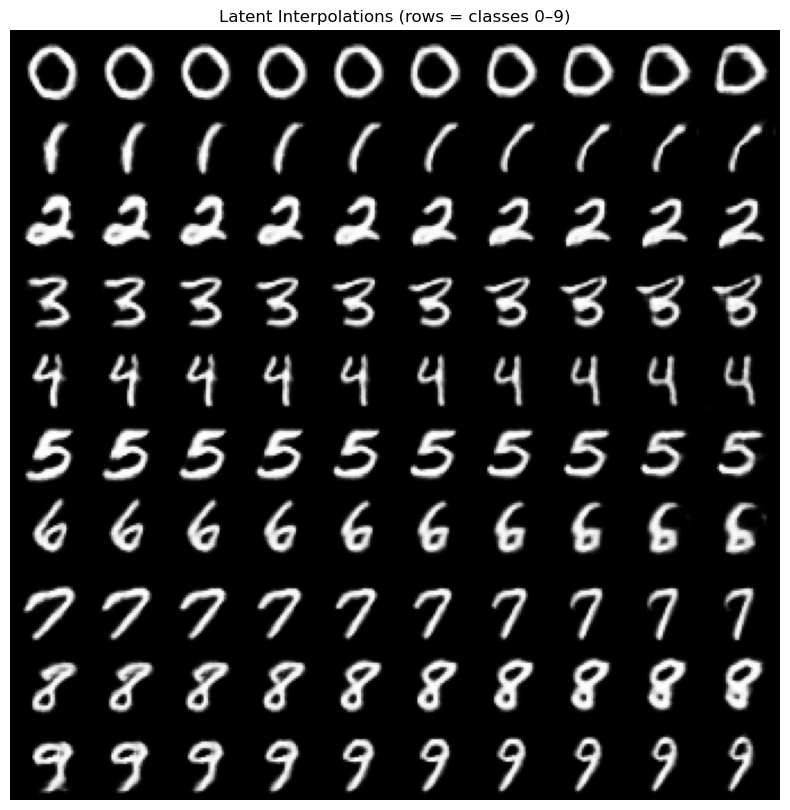

In [9]:
def interpolate(a, b, steps=10):
    """Linear interpolation between two latent vectors."""
    ratios = torch.linspace(0, 1, steps, device=device).view(-1, 1)
    return a.unsqueeze(0) * (1 - ratios) + b.unsqueeze(0) * ratios

rows = []
num_steps = 10
for c in range(num_classes):
    z1 = torch.randn(z_dim, device=device)
    z2 = torch.randn(z_dim, device=device)
    z_interp = interpolate(z1, z2, steps=num_steps).squeeze(1)
    y = torch.full((num_steps,), c, device=device, dtype=torch.long)
    with torch.no_grad():
        imgs = G_ema(z_interp, y)
    rows.append(imgs)

interpolations = torch.cat(rows, dim=0)
grid_interp = make_grid(interpolations, nrow=num_steps, normalize=True, value_range=(-1,1))
plt.figure(figsize=(num_steps, 10))
plt.imshow(grid_interp.permute(1,2,0).cpu())
plt.axis('off')
plt.title("Latent Interpolations (rows = classes 0–9)")
plt.show()

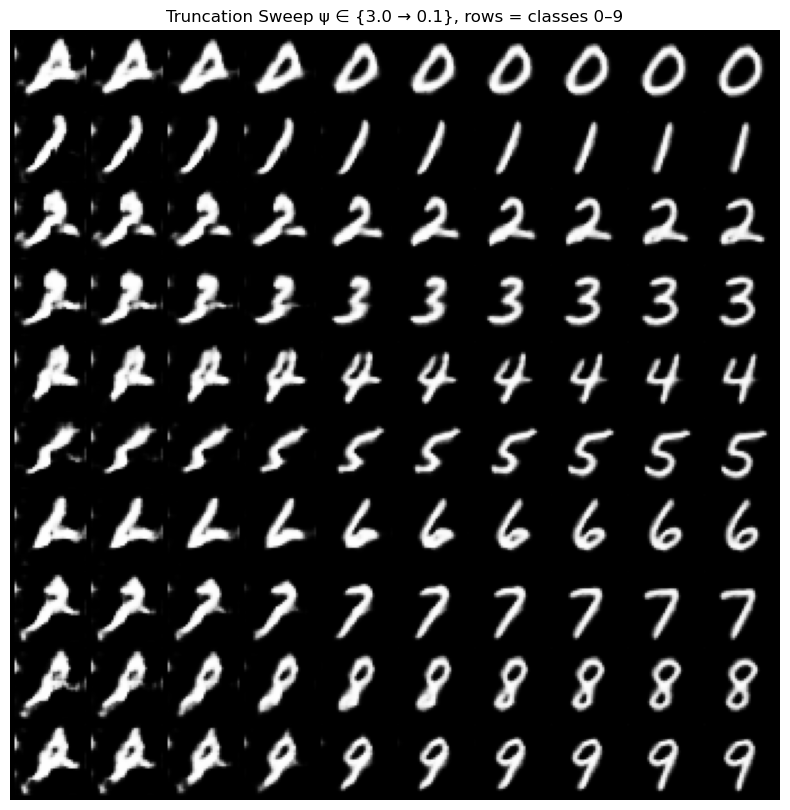

In [10]:
psi_values = [3.0, 2.5, 2.0, 1.5, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1]
rows = []

base_z = torch.randn(z_dim, device=device)

for c in range(num_classes):
    imgs_per_class = []
    for psi in psi_values:
        z_scaled = base_z * psi
        z_scaled = z_scaled.unsqueeze(0)
        y = torch.tensor([c], device=device)
        with torch.no_grad():
            img = G_ema(z_scaled, y)
        imgs_per_class.append(img)
    rows.append(torch.cat(imgs_per_class, dim=0))

truncation = torch.cat(rows, dim=0)
grid_trunc = make_grid(truncation, nrow=len(psi_values), normalize=True, value_range=(-1,1))
plt.figure(figsize=(len(psi_values), 10))
plt.imshow(grid_trunc.permute(1,2,0).cpu())
plt.axis('off')
plt.title("Truncation Sweep ψ ∈ {3.0 → 0.1}, rows = classes 0–9")
plt.show()